## Ensemble Model Tests. Best ensemble model with highest f1 score is XGBoost + TF-IDF/RF

In [7]:
import random
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime as dt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)
np.set_printoptions(suppress=True)


In [8]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [3]:
def plot_roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list
    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

# Load data

In [9]:
df_sf_2017 = pd.read_json('df_sf_2017')
df_sf_2017.loc[df_sf_2017.cancellation_policy == 'flexible_new', 'cancellation_policy'] = "flexible"
prop_type = set(df_sf_2017.property_type.values)
keep = ['Apartment', 'House', 'Condomonium']
drop = list(set(prop_type).difference(keep))
df_sf_2017['property_type_new'] = df_sf_2017['property_type']
df_sf_2017.loc[df_sf_2017.property_type.isin(drop), 'property_type_new'] = "Other"


df_sf_2017['amenities_count'] = (df_sf_2017.amenities.apply(lambda x: len(x.split(','))))
df_sf_2017.is_business_travel_ready.fillna(value='f', inplace=True)

df_sf_2017.security_deposit.fillna(value='$0.00', inplace=True)
df_sf_2017['security_deposit'].replace('[\$,]', '', regex=True, inplace=True)
df_sf_2017['security_deposit'] = df_sf_2017.security_deposit.astype(float) 

df_sf_2017.description.fillna(value='None', inplace=True)
df_sf_2017["description_new"] = df_sf_2017['description'].str.replace('[^\w\s]','')

In [10]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

## splitting of the non-text data

In [11]:
def split_num_data(start_month, end_month):
    X_test = df_sf_2017[df_sf_2017['month'] == end_month][columns_to_keep]
    y_test = df_sf_2017[df_sf_2017['month'] == end_month]['popular']
    return X_test, y_test

## splitting of the text data (requires NLP)

In [12]:
def split_str_data(start_month, end_month):
    df_X_train = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['description_new']
    y_train = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['popular']

    df_X_test = df_sf_2017[df_sf_2017['month'] == end_month]['description_new']
    y_test = df_sf_2017[df_sf_2017['month'] == end_month]['popular']
    return df_X_train, y_train, df_X_test, y_test

## NLP

In [137]:
#run with the TF-IDF
def run_tf_idf_vec(df_X_train, df_X_test):
    tf_idf_vectorizer_train = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
    X_train = tf_idf_vectorizer_train.fit_transform(df_X_train).toarray()
    tf_idf_vectorizer_test = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', vocabulary = tf_idf_vectorizer_train.vocabulary_)
    X_test = tf_idf_vectorizer_test.fit_transform(df_X_test).toarray()
    return X_test

In [23]:
#run with the CountVectorizer
def run_tf_vec(df_X_train, df_X_test):
    tf_vectorizer_train = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english').fit(df_X_train)
    X_train = tf_vectorizer_train.transform(df_X_train)
    
    tf_vectorizer_test = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', vocabulary = tf_vectorizer_train.vocabulary_).fit(df_X_test)
    X_test = tf_vectorizer_test.transform(df_X_test)
    
    return X_test

In [13]:
def predict_tf_rf(X_train, y_train, X_test, y_test):
    param_grid = {'n_estimators': [500, 1000], 
                  'class_weight': [None, {0: .8, 1: .2}, {0: .9, 1: .1}]}

    model = RandomForestClassifier()
    
    best_parameters = grid_searching(param_grid, model)
    print(best_parameters)
    rf = RandomForestClassifier(n_estimators = best_parameters['n_estimators'], 
                                n_jobs = -1, 
                                random_state = 0, 
                                max_depth = best_parameters['max_depth'], 
                                class_weight = best_parameters['class_weight'])
    
#     rf = RandomForestClassifier(n_estimators = 500, 
#                                 n_jobs = -1, 
#                                 random_state = 0, 
#                                 max_depth = None, 
#                                 class_weight = {0: .9, 1: .1})
    
    
    rf.fit(X_train, y_train)
    rf_str_pred_prob = rf.predict_proba(X_test)
    return rf_str_pred_prob

In [14]:
from sklearn.model_selection import GridSearchCV


In [15]:
def grid_searching (param_grid, model):

    grid_search = GridSearchCV(model, 
                               param_grid=param_grid, cv=5, 
                               n_jobs=-1, scoring=make_scorer(f1_score))
    fit = grid_search.fit(X_train_str, y_train)
    predicted = fit.predict(X_test_str)
    return grid_search.best_params_


## ENSEMBLE WITH XGBOOST and TF-IDF/RF

1 4 0
[[0.96524341 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.96524341 0.96536697 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741323 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.89550173 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.96524341 0.96536697 0.96253701 0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.94060773 0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741

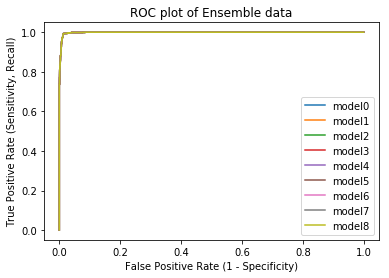

CPU times: user 8min 14s, sys: 23.3 s, total: 8min 37s
Wall time: 9min 11s


In [143]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    y_test = pd.DataFrame(np.array(y_test), columns=['y'])

    xgboost_num_model = pickle.load(open('xgboost_model' + str(model_num) +'.p', 'rb'))
    xgboost_num_pred_prob = xgboost_num_model.predict_proba(X_test_num)

    xgboost_num_output = pd.DataFrame(xgboost_num_pred_prob, columns=["xgboostnum - 0", "xgboostnum - 1"])
    xgboost_num_output.drop("xgboostnum - 0", axis=1, inplace=True)

    df_X_train, df_X_test = split_str_data(start_month, end_month)
    X_test_str = run_tf_idf_vec(df_X_train, df_X_test)

    rf_str_model = pickle.load(open('tf_idf_rf_descrip' + str(model_num) +'.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
        
    df_final = pd.concat([xgboost_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['xgboostnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)
    
    #plot ROC curves
    probabilities = np.array(df_final_combo['average'])
    labels = np.array(df_final_combo['y'])
    tprs1, fprs1, thresholds = plot_roc_curve(probabilities, labels)
    plt.plot(fprs, tprs, label = "test" + str(model_num))  
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of Ensemble data")
    plt.legend()
    
    model_num += 1
    start_month += 1
    end_month += 1

plt.show()

In [5]:
accuracy_2017 = np.mean(scores_ensemble[0])
recall_2017 = np.mean(scores_ensemble[1])
precision_2017 = np.mean(scores_ensemble[2])
f1_score_2017 = np.mean(scores_ensemble[3])
print(accuracy_2017) # ~96%
print(recall_2017) # ~94%
print(precision_2017) # ~86%
print(f1_score_2017) # ~90%

## Ensemble with XGBOOST and CountVectorizer/RF

In [26]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    

    xgboost_num_model = pickle.load(open('xgboost_model' + str(model_num) +'.p', 'rb'))
#     rf_num_model = pickle.load(open('rf_model1.p', 'rb'))
    xgboost_num_pred_prob = xgboost_num_model.predict_proba(X_test_num)
    print('mid0')
    xgboost_num_output = pd.DataFrame(xgboost_num_pred_prob, columns=["xgboostnum - 0", "xgboostnum - 1"])
    xgboost_num_output.drop("xgboostnum - 0", axis=1, inplace=True)
    print('mid2')
    df_X_train, y_train, df_X_test, y_test = split_str_data(start_month, end_month)
    print('mid3')
    X_test_str = run_tf_vec(df_X_train, df_X_test)
    print('mid1')
    rf_str_model = pickle.load(open('tf_rf_descrip' + str(model_num) +'.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
    y_test = pd.DataFrame(np.array(y_test), columns=['y'])
    
    df_final = pd.concat([xgboost_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['xgboostnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    print(df_final.columns)
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)

    model_num += 1
    start_month += 1
    end_month += 1


mid0
mid2
mid3
mid1
1 4 0
Index(['xgboostnum - 1', 'RFstr - 1', 'average'], dtype='object')
[[0.96547359 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.91683708 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88312541 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89966555 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
mid0
mid2
mid3
mid1
2 5 1
Index(['xgboostnum - 1', 'RFstr - 1', 'average'], dtype='object')
[[0.96547359 0.96364679 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.91683708 0.92847025 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88312541 0.85854617 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89966555 0.89214018 0.         0.         0.         0.
  0.         0.         0.        ]]
mid0
mid2
mid3
mid1
3 6 2
Index(['xgboostnum -

In [27]:
accuracy_2017 = np.mean(scores_ensemble[0])
recall_2017 = np.mean(scores_ensemble[1])
precision_2017 = np.mean(scores_ensemble[2])
f1_score_2017 = np.mean(scores_ensemble[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9598174813800004
0.9223311850206967
0.8741214873334691
0.8973667612443577


## ENSEMBLE with RANDOM FOREST and TF-IDF/RF

In [81]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    y_test = pd.DataFrame(np.array(y_test), columns=['y'])

    rf_num_model = pickle.load(open('rf_model' + str(model_num) +'.p', 'rb'))
#     rf_num_model = pickle.load(open('rf_model1.p', 'rb'))
    rf_num_pred_prob = rf_num_model.predict_proba(X_test_num)

    rf_num_output = pd.DataFrame(rf_num_pred_prob, columns=["RFnum - 0", "RFnum - 1"])
    rf_num_output.drop("RFnum - 0", axis=1, inplace=True)

    df_X_train, df_X_test = split_str_data(start_month, end_month)
    X_test_str = run_tf_idf_vec(df_X_train, df_X_test)

    rf_str_model = pickle.load(open('tf_idf_rf_descrip' + str(model_num) +'.p', 'rb')) 
#     rf_str_model = pickle.load(open('tf_idf_rf_descrip0.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
        
    df_final = pd.concat([rf_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['RFnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)
    
    model_num += 1
    start_month += 1
    end_month += 1


1 4 0
[[0.96259639 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88640336 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.96259639 0.96284404 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.97176471 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.81139489 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88640336 0.88436831 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.96259639 0.96284404 0.95820997 0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.97176471 0.95851852 0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.81139

In [83]:
accuracy_2017 = np.mean(scores_ensemble_ensemble[0])
recall_2017 = np.mean(scores_ensemble[1])
precision_2017 = np.mean(scores_ensemble[2])
f1_score_2017 = np.mean(scores_ensemble[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9566544297164883
0.955096658142044
0.8232753470921405
0.8839164063978197
